In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD, KNNBasic
from surprise.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from surprise.model_selection import train_test_split as ttsplit
import gcsfs
from surprise import accuracy
from sklearn.linear_model import LinearRegression

# Welcome to the Netflix recommender tutorial!

In this tutorial we are going to explore the Netflix dataset from the Netflix prize competition https://www.netflixprize.com/. This competition had $ 1 million dollars in prize money.

Recommendations are essential in Netflix, better recommendation improve the customer experience and improving these recommendations will eventually result in profits.

The dataset is very big, there are  initially it might look simple but there are quite some interesting aspects you have to take into account when creating an effective recommendation model. We have 480000 customers in the dataset and already 24 million ratings in just a segment of the dataset. 

As it is quite hard to work with the complete dataset we are going to work with a subset of 24M ratings in this tutorial, which is already a big dataset.

# Data loading

## Ratings

In [2]:
# Skip date
df = pd.read_csv('gs://codequarantine-tutorials/netflix/input/combined_data_1.txt', 
                  header = None, 
                  names = ['Cust_Id', 'Rating', 'date'], 
                  usecols = [0,1,2])

df['Rating'] = df['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Dataset 1 shape: (24058263, 3)
-Dataset examples-
          Cust_Id  Rating        date
0              1:     NaN         NaN
5000000   2560324     4.0  2005-12-06
10000000  2271935     2.0  2005-04-11
15000000  1921803     2.0  2005-01-31
20000000  1933327     3.0  2004-11-10


In [3]:
df_nan = df[df.Rating.isna()].copy()

In [4]:
df_nan['movie_id'] = df_nan['Cust_Id']

In [5]:
df.loc[df_nan.index, 'movie_id'] = df_nan['movie_id']

In [6]:
df.movie_id.ffill(inplace=True)

In [7]:
df.dropna(inplace=True)

In [8]:
df['movie_id'] = df.movie_id.str.replace(':', '')

In [9]:
df['movie_id'] = df.movie_id.astype(int)

In [10]:
df['date'] = pd.to_datetime(df['date'])

In [11]:
df['month_year'] = df.date.dt.to_period('M')

In [12]:
df['weekday'] = df.date.dt.weekday

## Movie titles

We have a separate movie title dataset. The movie id's correspond to the movie id's in the rating dataset. 

In [13]:
df_titles = pd.read_csv('gs://codequarantine-tutorials/netflix/input/movie_titles.csv',
                        header=None,
                        usecols=[0,1,2],
                        names=['movie_id', 'year', 'title'],
                        encoding = "ISO-8859-1")

In [14]:
df_titles

movie_id    year                                              title
0             1  2003.0                                    Dinosaur Planet
1             2  2004.0                         Isle of Man TT 2004 Review
2             3  1997.0                                          Character
3             4  1994.0                       Paula Abdul's Get Up & Dance
4             5  2004.0                           The Rise and Fall of ECW
5             6  1997.0                                               Sick
6             7  1992.0                                              8 Man
7             8  2004.0                         What the #$*! Do We Know!?
8             9  1991.0                           Class of Nuke 'Em High 2
9            10  2001.0                                            Fighter
10           11  1999.0                     Full Frame: Documentary Shorts
11           12  1947.0                               My Favorite Brunette
12           13  2003.0  Lord of the Rings: The Return of the King: Ext...
13           14  1982.0                                 Nature: Antarctica
14           15  1988.0                   Neil Diamond: Greatest Hits Live
15           16  1996.0                                          Screamers
16           17  2005.0                                          7 Seconds
17           18  1994.0                                   Immortal Beloved
18           19  2000.0                              By Dawn's Early Light
19           20  1972.0                                    Seeta Aur Geeta
20           21  2002.0                                  Strange Relations
21           22  2000.0                                       Chump Change
22           23  2001.0  Clifford: Clifford Saves the Day! / Clifford's...
23           24  1981.0                                My Bloody Valentine
24           25  1997.0      Inspector Morse 31: Death Is Now My Neighbour
25           26  2004.0                                    Never Die Alone
26           27  1962.0  Sesame Street: Elmo's World: The Street We Liv...
27           28  2002.0                                    Lilo and Stitch
28           29  2001.0                                            Boycott
29           30  2003.0                             Something's Gotta Give
...         ...     ...                                                ...
17740     17741  2004.0                          Ginger Snaps 2: Unleashed
17741     17742  1995.0                                Catherine the Great
17742     17743  2003.0                               Better Luck Tomorrow
17743     17744  2004.0                         NASCAR: Tony Stewart Smoke
17744     17745  2002.0      Russell Simmons Presents Def Poetry: Season 1
17745     17746  1991.0  Godzilla & Mothra: Battle for Earth / Vs. King...
17746     17747  1991.0                            Eric Clapton: 24 Nights
17747     17748  2005.0        Dog the Bounty Hunter: The Best of Season 1
17748     17749  1985.0                                             No End
17749     17750  2005.0                     The Hee Haw Collection: Vol. 4
17750     17751  1993.0                               Highlander: Season 2
17751     17752  2003.0                                       Out of Order
17752     17753  1997.0                                       Maslin Beach
17753     17754  1999.0                                       On the Ropes
17754     17755  2003.0                           L/R: Licensed by Royalty
17755     17756  1935.0                                       The 39 Steps
17756     17757  2002.0  Ulysses S. Grant: Warrior / President: America...
17757     17758  1979.0                                           Prophecy
17758     17759  1972.0                                  The Big Bird Cage
17759     17760  2004.0                                      Lightning Bug
17760     17761  2003.0                                             Levity
17761     17762  1997.0         

# Data exploration

In [15]:
# Check structure of the dataset
df.head()

Cust_Id  Rating       date  movie_id month_year  weekday
1  1488844     3.0 2005-09-06         1    2005-09        1
2   822109     5.0 2005-05-13         1    2005-05        4
3   885013     4.0 2005-10-19         1    2005-10        2
4    30878     4.0 2005-12-26         1    2005-12        0
5   823519     3.0 2004-05-03         1    2004-05        0

In [16]:
df.tail()

Cust_Id  Rating       date  movie_id month_year  weekday
24058258  2591364     2.0 2005-02-16      4499    2005-02        2
24058259  1791000     2.0 2005-02-10      4499    2005-02        3
24058260   512536     5.0 2005-07-27      4499    2005-07        2
24058261   988963     3.0 2005-12-20      4499    2005-12        1
24058262  1704416     3.0 2004-06-02      4499    2004-06        2

In [17]:
# That's a lot of rows!
df.shape

(24053764, 6)

In [18]:
# Check number of unique users
df.Cust_Id.unique().shape

(470758,)

In [19]:
# Check number of unique movies
df.movie_id.unique().shape

(4499,)

In [20]:
# Check average rating, it's quite high 
df.Rating.mean()

3.5996343025565563

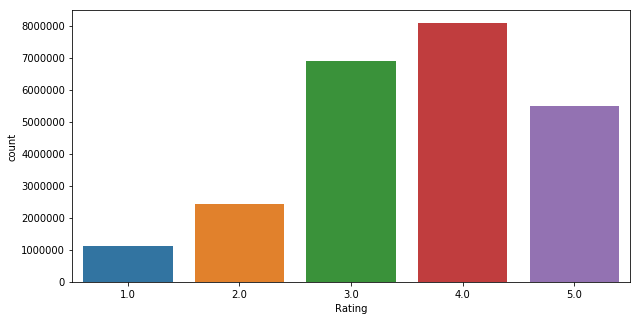

In [21]:
# Count individual ratings
plt.figure(figsize=(10,5))
sns.countplot('Rating', data=df)

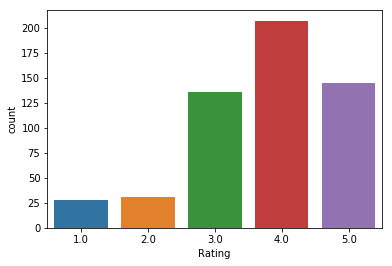

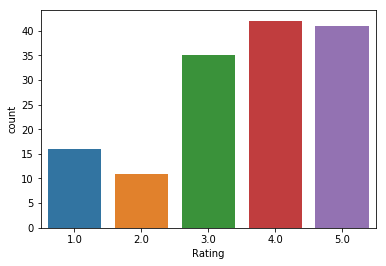

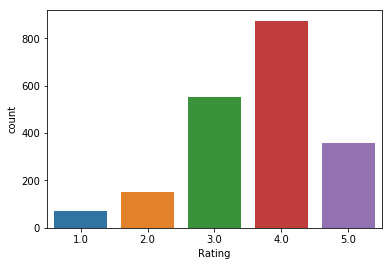

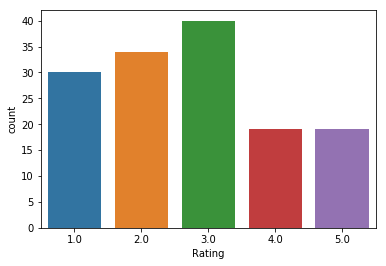

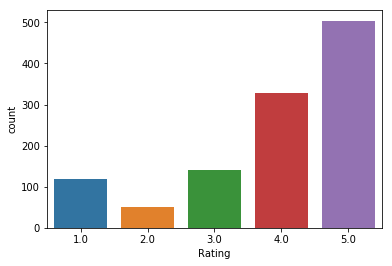

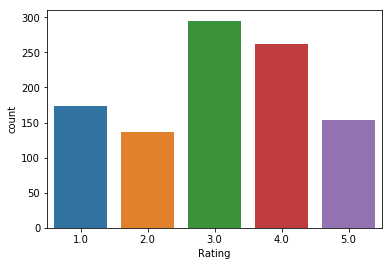

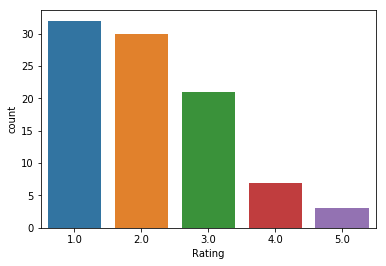

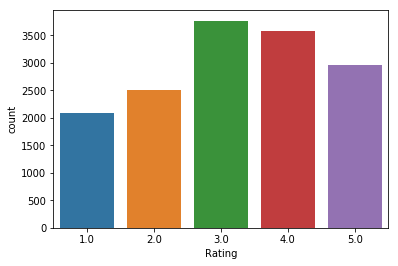

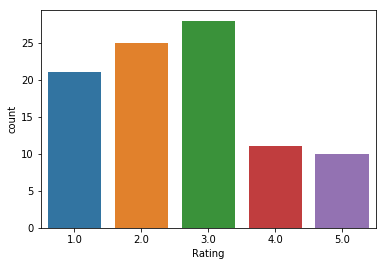

In [22]:
# Check ratings for some movies
for i in range(1, 10):
    plt.figure()
    sns.countplot('Rating', data=df[df.movie_id == i])

### Are movies getting better?

In [23]:
# Group by date
grouped = df.groupby('date')

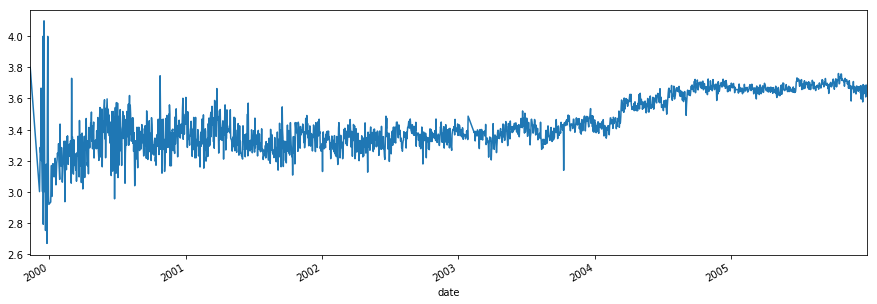

In [24]:
plt.figure(figsize=(15, 5))
grouped.Rating.mean().plot()

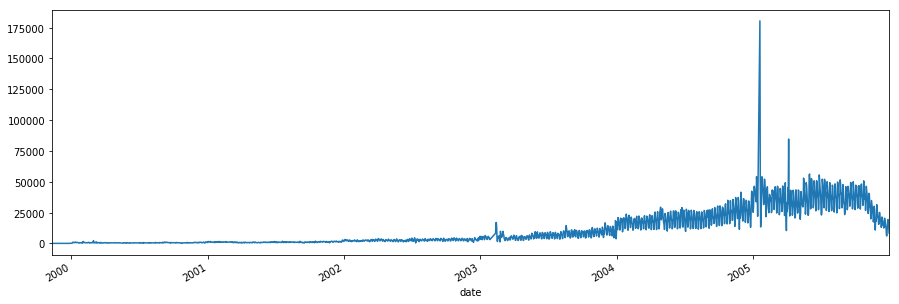

In [25]:
plt.figure(figsize=(15, 5))
grouped.Rating.count().plot()

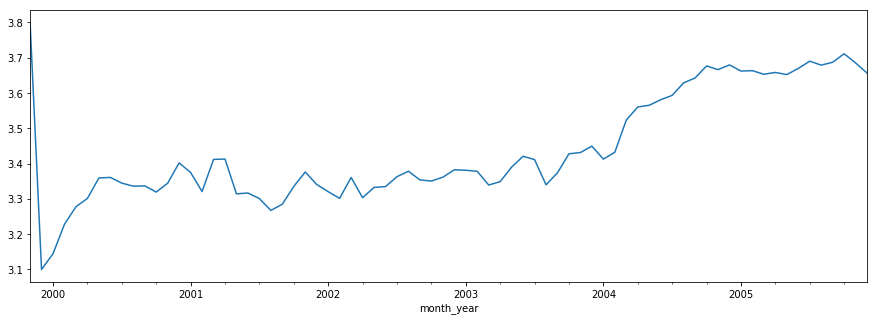

In [26]:
plt.figure(figsize=(15, 5))
df.groupby('month_year').Rating.mean().plot()

In [27]:
# Count number of ratings for each movie
counts = df.groupby(['movie_id']).Rating.count().reset_index()
counts.columns = ['movie_id', 'movie_rating_count']
df = pd.merge(df, counts, on='movie_id')

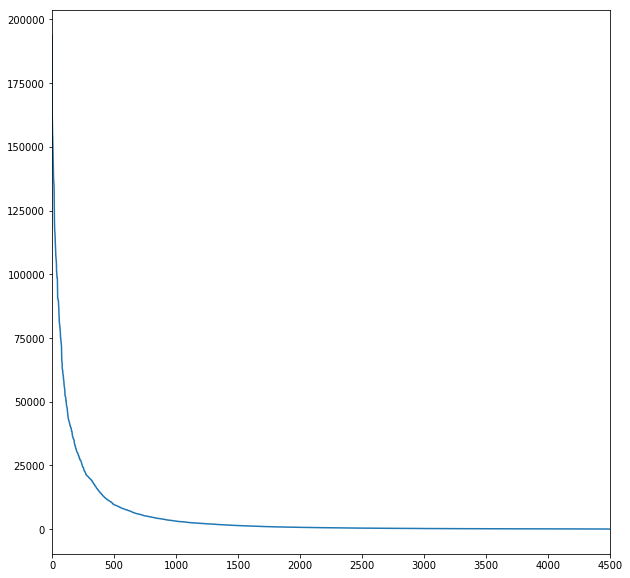

In [28]:
counts.sort_values('movie_rating_count', ascending=False).reset_index().movie_rating_count.plot(figsize=(10,10))

We can see that some movies are rated much much more then others

In [29]:
sub = df[df.movie_rating_count > 100]

In [30]:
# Rank movies by highest average rating, with at least 100 votes
ranked_movies = sub.groupby('movie_id').Rating.mean().sort_values(ascending=False).reset_index()
ranked_movies.columns = ['movie_id', 'avg_rating']

In [31]:
ranked_movies = pd.merge(ranked_movies, df_titles, on='movie_id')

In [32]:
ranked_movies

movie_id  avg_rating    year  \
0         3456    4.670989  2004.0   
1         3033    4.586364  2005.0   
2         2102    4.581296  1994.0   
3         4238    4.554434  2000.0   
4           13    4.552000  2003.0   
5         3444    4.516007  2004.0   
6         4427    4.473692  2001.0   
7         1476    4.469693  2004.0   
8         2019    4.467500  2004.0   
9         1418    4.464824  2002.0   
10        2568    4.461921  2004.0   
11        1947    4.448333  2002.0   
12        2114    4.446714  2002.0   
13        2452    4.434708  2001.0   
14        3962    4.415523  2003.0   
15         724    4.408013  1992.0   
16        2172    4.404792  1991.0   
17        3290    4.404083  1974.0   
18        1072    4.398458  2000.0   
19        2162    4.396755  2000.0   
20        2117    4.393701  2004.0   
21        3046    4.386774  1990.0   
22        1357    4.381994  2003.0   
23        2057    4.380080  2001.0   
24        1587    4.369863  1962.0   
25        1499    4.360746  2000.0   
26        1915    4.352338  2000.0   
27        1256    4.348704  1994.0   
28        3067    4.348485  2004.0   
29        1495    4.344422  2001.0   
...        ...         ...     ...   
4208      4126    1.826923  1996.0   
4209      1059    1.817680  2000.0   
4210      3459    1.816456  2000.0   
4211      2602    1.811429  1984.0   
4212      3850    1.810345  2000.0   
4213      1342    1.801527  2003.0   
4214      3667    1.762584  1986.0   
4215      1640    1.762376  2002.0   
4216       415    1.761905  2002.0   
4217      1924    1.759690  2002.0   
4218      3697    1.745614  2002.0   
4219      3849    1.741697  1987.0   
4220      3488    1.727723  2002.0   
4221       995    1.721154  2004.0   
4222      3561    1.713514  2001.0   
4223      2999    1.704663  2003.0   
4224      3041    1.703704  2000.0   
4225        53    1.675439  2003.0   
4226      2970    1.662791  2004.0   
4227      3118    1.651515  2001.0   
4228      3845    1.642276  2005.0   
4229      3556    1.627451  2005.0   
4230      1791    1.615385  1999.0   
4231      1725    1.522137  2003.0   
4232       625    1.505034  1999.0   
4233      1569    1.497758  2000.0   
4234      1227    1.496241  2005.0   
4235      4202    1.487395  2004.0   
4236      3575    1.400000  2005.0   
4237       515    1.287879  2005.0   

                                                  title  
0                                        Lost: Season 1  
1      Ghost in the Shell: Stand Alone Complex: 2nd Gig  
2                                The Simpsons: Season 6  
3                                             Inu-Yasha  
4     Lord of the Rings: The Return of the King: Ext...  
5                 Family Guy: Freakin' Sweet Collection  
6                               The West Wing: Season 3  
7                              Six Feet Under: Season 4  
8                                      Samurai Champloo  
9     Inu-Yasha: The Movie 3: Swords of an Honorable...  
10                              Stargate SG-1: Season 8  
11                              Gilmore Girls: Season 3  
12                                              Firefly  
13        Lord of the Rings: The Fellowship of the Ring  
14                            Finding Nemo (Widescreen)  
15                                        Yu Yu Hakusho  
16                               The Simpsons: Season 3  
17                                        The Godfather  
18                            As Time Goes By: Series 8  
19                                        CSI: Season 1  
20                                Case Closed: Season 5  
21                    The Simpsons: Treehouse of Horror  
22                              Stargate SG-1: Season 7  
23                   Buffy the Vampire Slayer: Season 6  
24                                             Harakiri  
25                                                 FLCL  
26    Law & Order: Special Victims Unit: The Second ...  
27                       

# Exercise: data exploration!

- Try to understand the exploratory data analysis I have made so far
- Try to visualize more aspects of the data

Hints:

- Does the day of the week matter?
- Do users rate different over time?

In [1]:
df.groupby('weekday').Rating.mean()

NameError: name 'df' is not defined

In [34]:
df.loc[df.Cust_Id == '2590061'].groupby('weekday').Rating.mean()

weekday
0    3.651163
1    3.791667
2    3.935484
3    3.548387
4    3.678571
5    4.000000
6    3.888889
Name: Rating, dtype: float64

In [35]:
df['user_rating_cumcount'] =  df.sort_values('date').groupby('Cust_Id').cumcount() + 1

Text(0.5, 0, 'Number of ratings given')

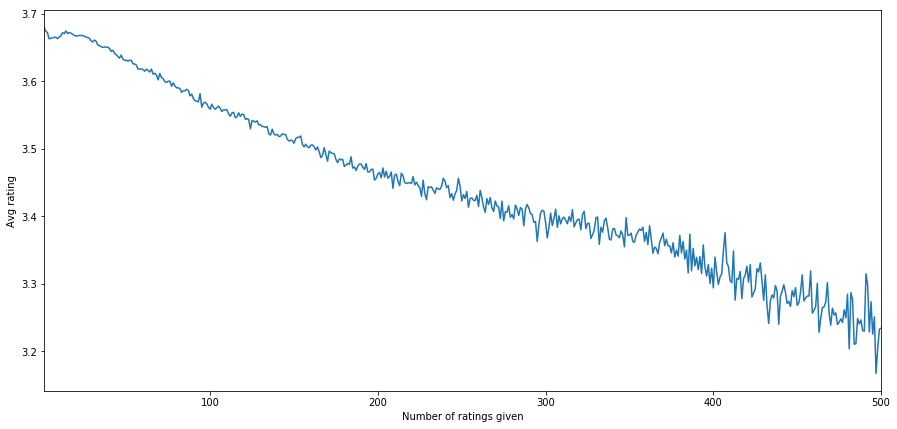

In [41]:
plt.figure(figsize=(15,7))
df.groupby('user_rating_cumcount').Rating.mean()[0:500].plot()
plt.ylabel('Avg rating')
plt.xlabel('Number of ratings given')

In [37]:
df['movie_rating_cumcount'] = df.sort_values('date').groupby('movie_id').cumcount()

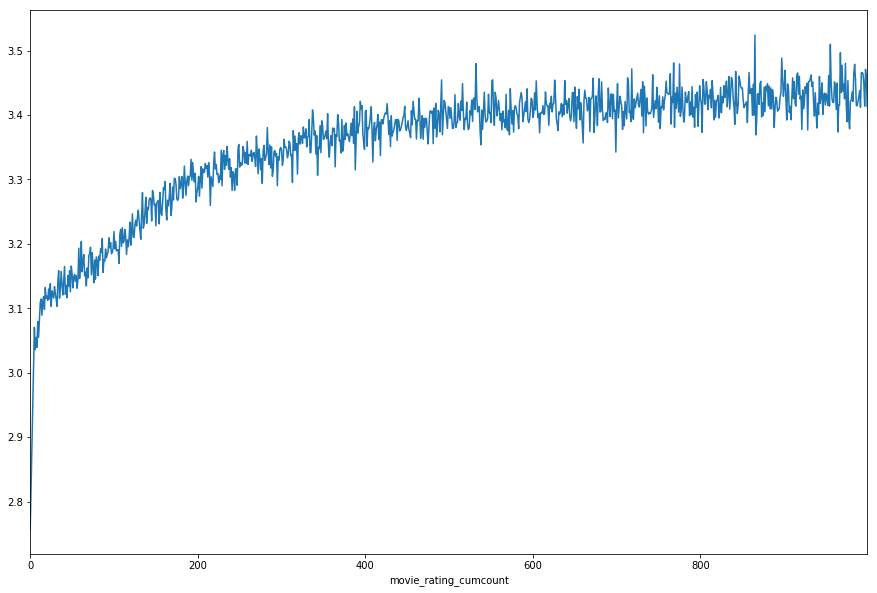

In [38]:
df.groupby('movie_rating_cumcount').Rating.mean()[0:1000].plot(figsize=(15,10))

In [39]:
# expanding_mean = df.sort_values('date').groupby('movie_id').Rating.expanding().mean()

In [40]:
# df['expanding_mean'] = expanding_mean.reset_index().set_index('level_1')[['Rating']]

# Base model(s)

In [41]:
train, test = train_test_split(df, random_state=1)

In [42]:
def add_mean_all_movies(train, test):
    """
    Add a column with the average rating of all ratings
    """
    mean = train.Rating.mean()
    train['mean_rating_overall'] = mean
    test['mean_rating_overall'] = mean

In [43]:
def add_mean_specific_movie(train, test):
    """
    Add a column with the mean rating of a specific movie
    """
    means = train.groupby('movie_id').Rating.mean().reset_index()
    means.columns = ['movie_id', 'movie_rating_mean']
    train = pd.merge(train, means, on='movie_id')
    test = pd.merge(test, means, on='movie_id')
    return train, test

In [44]:
def add_customer_avg_rating(train, test):
    """
    Add column with average rating from a customer
    """
    grouped = train.groupby('Cust_Id').Rating.mean()
    grouped = grouped.reset_index()
    grouped.columns = ['Cust_Id', 'customer_avg_rating']
    train = pd.merge(train, grouped, on='Cust_Id')
    test = pd.merge(test, grouped, on='Cust_Id')
    return train, test

In [45]:
def create_features(df):
    train, test = train_test_split(df, random_state=1)
    train = train.copy()
    test = test.copy()
    add_mean_all_movies(train, test)
    train, test = add_mean_specific_movie(train, test)
    train, test = add_customer_avg_rating(train, test)
    return train, test
train, test = create_features(df)

In [46]:
del df

In [47]:
print(mse(train['Rating'], train['mean_rating_overall'], squared=False))
print(mse(test['Rating'], test['mean_rating_overall'], squared=False))

1.0860711036906239
1.0861282723093566


In [48]:
print(mse(train['Rating'], train['movie_rating_mean'], squared=False))
print(mse(test['Rating'], test['movie_rating_mean'], squared=False))

1.0130165065497654
1.0133083673913832


In [49]:
print(mse(train['Rating'], train['customer_avg_rating'], squared=False))
print(mse(test['Rating'], test['customer_avg_rating'], squared=False))

0.9826620992615349
1.0114793971534133


In [50]:
train['pred'] = (train['movie_rating_mean'] + train['movie_rating_mean']) / 2
test['pred'] = (test['movie_rating_mean'] + test['movie_rating_mean']) / 2

In [51]:
print(mse(train['Rating'], train['pred'], squared=False))
print(mse(test['Rating'], test['pred'], squared=False))

1.0130165065497654
1.0133083673913832


# Try to figure out more base models

Hints:

- Weekday model?
- Expanding mean?
- Other?


In [52]:
weekdays = train.groupby(['weekday', 'Cust_Id']).Rating.mean().reset_index()
weekdays.columns = ['weekday', 'Cust_Id', 'weekday_rating_user']
pd.merge(train, weekdays, on=['weekday', 'Cust_Id'])

Cust_Id  Rating       date  movie_id month_year  weekday  \
0         1930480     3.0 2004-10-29      3817    2004-10        4   
1         1930480     1.0 2002-06-14      2800    2002-06        4   
2         1930480     4.0 2004-03-12       720    2004-03        4   
3         1930480     1.0 2005-04-22       482    2005-04        4   
4         1930480     4.0 2004-02-20      1305    2004-02        4   
5         1930480     2.0 2003-11-07      3925    2003-11        4   
6         1930480     5.0 2004-03-12      2465    2004-03        4   
7         1930480     4.0 2004-08-27      3489    2004-08        4   
8         1930480     4.0 2004-05-07      1754    2004-05        4   
9         1930480     3.0 2003-01-24      2578    2003-01        4   
10        1930480     2.0 2002-06-14      3725    2002-06        4   
11        1930480     2.0 2001-09-07      3267    2001-09        4   
12        1930480     3.0 2004-03-12       433    2004-03        4   
13        1930480     3.0 2004-03-12      3331    2004-03        4   
14        1930480     1.0 2002-06-14      2988    2002-06        4   
15        1930480     5.0 2001-08-18       241    2001-08        5   
16        1930480     5.0 2005-01-08      3917    2005-01        5   
17        1930480     2.0 2001-08-18      4306    2001-08        5   
18        1930480     3.0 2001-08-18      4123    2001-08        5   
19        1930480     2.0 2005-06-25      1307    2005-06        5   
20        1930480     3.0 2005-08-06      3282    2005-08        5   
21        1930480     5.0 2001-08-18      2122    2001-08        5   
22        1930480     1.0 2001-08-18       819    2001-08        5   
23        1930480     3.0 2001-08-18      2360    2001-08        5   
24        1930480     1.0 2001-08-18      3085    2001-08        5   
25        1930480     4.0 2001-08-18      2554    2001-08        5   
26        1930480     4.0 2001-09-08      1542    2001-09        5   
27        1930480     3.0 2002-12-28      3427    2002-12        5   
28        1930480     3.0 2005-08-06      3151    2005-08        5   
29        1930480     4.0 2001-09-08      3541    2001-09        5   
...           ...     ...        ...       ...        ...      ...   
18040293  1361370     4.0 2002-09-16      1545    2002-09        0   
18040294  1888032     4.0 2005-11-07      1135    2005-11        0   
18040295   470644     4.0 2005-04-03      2502    2005-04        6   
18040296  2530064     3.0 2005-12-02      3241    2005-12        4   
18040297  1115440     5.0 2002-01-29      3871    2002-01        1   
18040298  1255402     5.0 2005-05-11       277    2005-05        2   
18040299  2115065     1.0 2005-12-26      4058    2005-12        0   
18040300  2327324     3.0 2004-11-01      4318    2004-11        0   
18040301   869095     5.0 2005-11-11      3067    2005-11        4   
18040302  1481575     4.0 2005-11-07      4338    2005-11        0   
18040303  2029372     5.0 2004-12-16      1444    2004-12        3   
18040304   220023     4.0 2003-08-30      1444    2003-08        5   
18040305  1570871     5.0 2005-08-21      1444    2005-08        6   
18040306  1958846     3.0 2005-10-30      2614    2005-10        6   
18040307  1711156     5.0 2005-12-14      2598    2005-12        2   
18040308  1487845     3.0 2005-10-05      1714    2005-10        2   
18040309  1606043     5.0 2005-09-12      1966    2005-09        0   
18040310   269904     3.0 2003-11-03      1820    2003-11        0   
18040311  1706586     5.0 2005-11-10      4373    2005-11        3   
18040312   392008     5.0 2005-05-21      3953    2005-05        5   
18040313   232171     3.0 2005-03-07      1815    2005-03        0   
18040314   830546     3.0 2005-02-02      3795    2005-02        2   
18040315  2162054     1.0 2005-02-14        34    2005-02        0   
18040316   106932     5.0 2005-12-20      1247    2005-12        1   
18040317   706795     4.0 2005-11-28      1261    2005-11        0   
18040318  1590572   

In [53]:
# Weekday model
def add_weekday_global_mean(train, test):
    weekdays = train.groupby('weekday').Rating.mean().reset_index()
    weekdays.columns = ['weekday', 'weekday_rating_global']
    train = pd.merge(train, weekdays, on='weekday')
    test = pd.merge(test, weekdays, on='weekday')
    return train, test

def add_weekday_user_mean(train, test):
    weekdays = train.groupby(['weekday', 'Cust_Id']).Rating.mean().reset_index()
    weekdays.columns = ['weekday', 'Cust_Id', 'weekday_rating_user']
    train = pd.merge(train, weekdays, on=['weekday', 'Cust_Id'])
    test = pd.merge(test, weekdays, on=['weekday', 'Cust_Id'])
    return train, test

def add_weekday_movie_mean(train, test):
    weekdays = train.groupby(['weekday', 'movie_id']).Rating.mean().reset_index()
    weekdays.columns = ['weekday', 'movie_id', 'weekday_rating_movie']
    train = pd.merge(train, weekdays, on=['weekday', 'movie_id'])
    test = pd.merge(test, weekdays, on=['weekday', 'movie_id'])
    return train, test

train, test = add_weekday_global_mean(train, test)
train, test = add_weekday_user_mean(train, test)
train, test = add_weekday_movie_mean(train, test)

In [54]:
print(mse(train['Rating'], train['weekday_rating_global'], squared=False))
print(mse(test['Rating'], test['weekday_rating_global'], squared=False))
print('-----')
print(mse(train['Rating'], train['weekday_rating_user'], squared=False))
print(mse(test['Rating'], test['weekday_rating_user'], squared=False))
print('----')
print(mse(train['Rating'], train['weekday_rating_movie'], squared=False))
print(mse(test['Rating'], test['weekday_rating_movie'], squared=False))

1.0860520417143271
1.0848647134067713
-----
0.9246760037138076
1.0382742939844547
----
1.011964155995854
1.0130030187044599


In [55]:
# Expanding mean
def add_expanding_mean(train, test):
    expanding_mean_train = train.sort_values('date').groupby('movie_id').Rating.expanding().mean()
    train['expanding_mean'] = expanding_mean_train.reset_index().set_index('level_1')[['Rating']]
    test = pd.merge(test, train[['date', 'movie_id', 'expanding_mean']].drop_duplicates(subset=['date', 'movie_id'])[['date', 'movie_id', 'expanding_mean']], on=['date', 'movie_id'], how='left')
    test['expanding_mean'] =  test.sort_values('date').groupby('movie_id').expanding_mean.ffill()
    test['expanding_mean'] = test.sort_values('date').groupby('movie_id').expanding_mean.bfill()
    test.expanding_mean.fillna(test.expanding_mean.mean(), inplace=True)
    return train, test
train, test = add_expanding_mean(train, test)

In [56]:
print(mse(train['Rating'], train['expanding_mean'], squared=False))
print(mse(test['Rating'], test['expanding_mean'], squared=False))

1.0120875203487112
1.0135292244208853


# Further preprocessing

In [57]:
optimization_var = 'Rating'
reader = Reader(rating_scale=(min(train[optimization_var]), max(train[optimization_var])))
traindata = Dataset.load_from_df(train[['Cust_Id', 'movie_id', optimization_var]][:], reader).build_full_trainset()
testdata = Dataset.load_from_df(test[['Cust_Id', 'movie_id',  optimization_var]][:], reader).build_full_trainset().build_testset()

# KNN Collaborative filtering - Item based

KNN collaborative filtering will determine the similarity between each item based on the users feedback. It will use the K nearest neighbours (most similar items) to predict the users preference. 

In [58]:
# Initialize KNN
algo = KNNBasic(k=5, verbose=True, sim_options={'user_based': False, 'name': 'pearson'})

In [1]:
# Fit model
algo.fit(traindata)

NameError: name 'algo' is not defined

In [ ]:
# Make predictions and test root mean squared error on test set
predictions_test = algo.test(testdata)
accuracy.rmse(predictions_test)

In [ ]:
# Calculate mean absolute error on test set
accuracy.mae(predictions_test)

In [ ]:
# Check movie id
df_titles.loc[df_titles['movie_id'] == 4238]['title'].values[0]

In [ ]:
def print_similar_movies(algo, movie_id, movie_titles, nr_recommendations):
    """
    Print similar movies based on the KNN model
    """
    recommendations = algo.get_neighbors(movie_id, nr_recommendations)
    for r in recommendations:
        rec_title = df_titles.loc[df_titles['movie_id'] == r]['title'].values[0]
        print(rec_title)

In [ ]:
print_similar_movies(algo, 4238, df_titles, 10)

# Matrix Factorization

In [ ]:
# Create classifier
algo = SVD(n_factors=10, n_epochs=5, verbose=True, random_state=123)

In [ ]:
# Fit the model
algo.fit(traindata)

In [ ]:
# Create validation predictions
predictions_test = algo.test(testdata)

In [ ]:
# Calculate root mean squared error on validation data
accuracy.rmse(predictions_test)

In [ ]:
# Calculate mean absolute error on validation data
accuracy.mae(predictions_test)

In [ ]:
# Add test predictions to test dataset
preds = pd.DataFrame(predictions_test)[['uid', 'iid', 'est']]
del predictions_test
preds.columns = ['Cust_Id', 'movie_id', 'svd_preds']
test = pd.merge(test, preds, on=['Cust_Id', 'movie_id'])

In [ ]:
# Add train predictions to train dataset
traindata_formatted = Dataset.load_from_df(train[['Cust_Id', 'movie_id', optimization_var]][:], reader).build_full_trainset().build_testset()

predictions_train = algo.test(traindata_formatted)
preds = pd.DataFrame(predictions_train)[['uid', 'iid', 'est']]
del predictions_train
preds.columns = ['Cust_Id', 'movie_id', 'svd_preds']
train = pd.merge(train, preds, on=['Cust_Id', 'movie_id'])
del traindata_formatted
del testdata

In [ ]:
del algo

# Ensemble different models

In [ ]:
# Select features for final model
features = ['mean_rating_overall', 'movie_rating_mean', 'customer_avg_rating', 'svd_preds']

In [ ]:
# Create subset of dataframe
train_lin = train[['Rating'] + features]
test_lin = test[['Rating'] + features]

In [ ]:
# split target from features
train_feats = train[features]
train_y = train.Rating

In [ ]:
# Train a simple linear model
clf = LinearRegression().fit(train_feats, train_y)

In [ ]:
# Predict test set
p = clf.predict(test_lin[features])

In [ ]:
# Determine root mean squared error
mse(test['Rating'], p, squared=False)

In [ ]:
# Determine mean absolute error
mae(test['Rating'], p)

In [ ]:
# Check coefficients to see which features were most important
clf.coef_

# Exercise: Improve the model!

Ways to improve:

- Check out other recommendation models on surprise https://surprise.readthedocs.io/en/stable/index.html
- Tune the hyperparameters
- Add more models to the ensemble
- Add more features to the ensemble